<a href="https://colab.research.google.com/github/mairovitzmario/data_science_notebooks/blob/main/dev_productivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load Kaggle Data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
dataset_link = "atharvasoundankar/ai-developer-productivity-dataset"

In [ ]:
author, name = dataset_link.split('/')[:2]

In [ ]:
print(author)

atharvasoundankar


In [ ]:
!kaggle datasets download -d {dataset_link}


Dataset URL: https://www.kaggle.com/datasets/atharvasoundankar/ai-developer-productivity-dataset
License(s): apache-2.0
  0% 0.00/5.85k [00:00<?, ?B/s]
100% 5.85k/5.85k [00:00<00:00, 13.4MB/s]


In [ ]:
zip_filename = f"/content/{name}.zip"

# Unzip the dataset
!unzip -q {zip_filename} -d /content/{name}

In [ ]:
import pandas as pd

df = pd.read_csv(f'/content/ai-developer-productivity-dataset/ai_dev_productivity.csv')
df.head()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


# 1. Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

# 2. Understanding and Cleaning Data

In [ ]:
df.head()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      500 non-null    float64
 1   coffee_intake_mg  500 non-null    int64  
 2   distractions      500 non-null    int64  
 3   sleep_hours       500 non-null    float64
 4   commits           500 non-null    int64  
 5   bugs_reported     500 non-null    int64  
 6   ai_usage_hours    500 non-null    float64
 7   cognitive_load    500 non-null    float64
 8   task_success      500 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


We don't have any null values

In [ ]:
df.isna().sum().sum()

np.int64(0)

In [ ]:
df.describe()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.015600,463.192000,2.976000,6.975800,4.60800,0.858000,1.510920,4.498200,0.606000
std,1.947253,142.334991,1.678409,1.455965,2.70499,1.102846,1.085557,1.868861,0.489124
min,0.000000,6.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,3.600000,369.500000,2.000000,6.100000,3.00000,0.000000,0.697500,3.175000,0.000000
50%,5.030000,500.500000,3.000000,6.950000,5.00000,0.000000,1.260000,4.400000,1.000000
75%,6.275000,600.000000,4.000000,7.900000,6.00000,2.000000,2.070000,5.800000,1.000000
max,12.000000,600.000000,8.000000,10.000000,13.00000,5.000000,6.360000,10.000000,1.000000


In [ ]:
df['task_success'].value_counts()

,count
task_success,
1,303
0,197


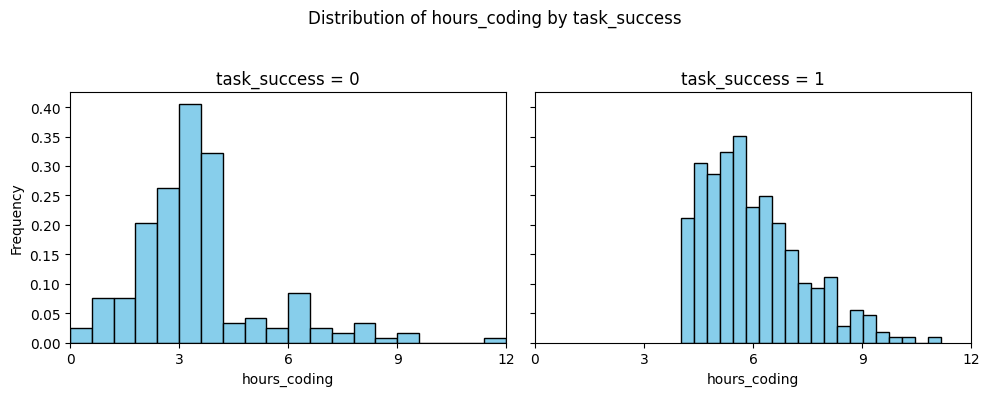

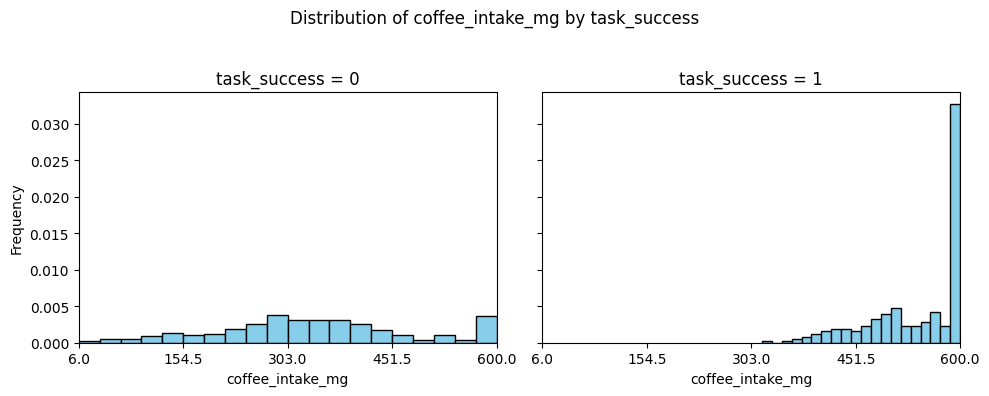

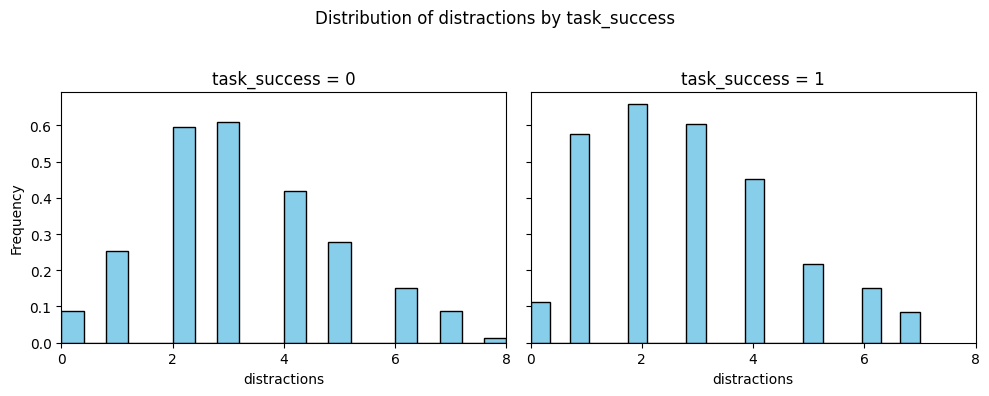

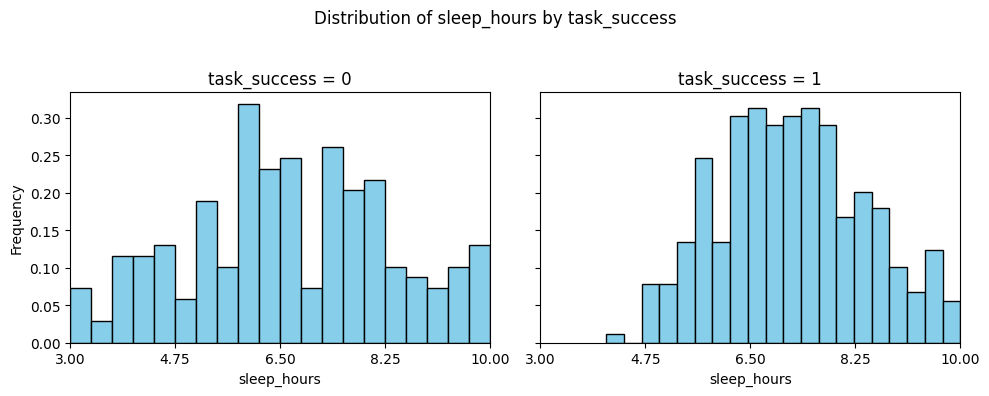

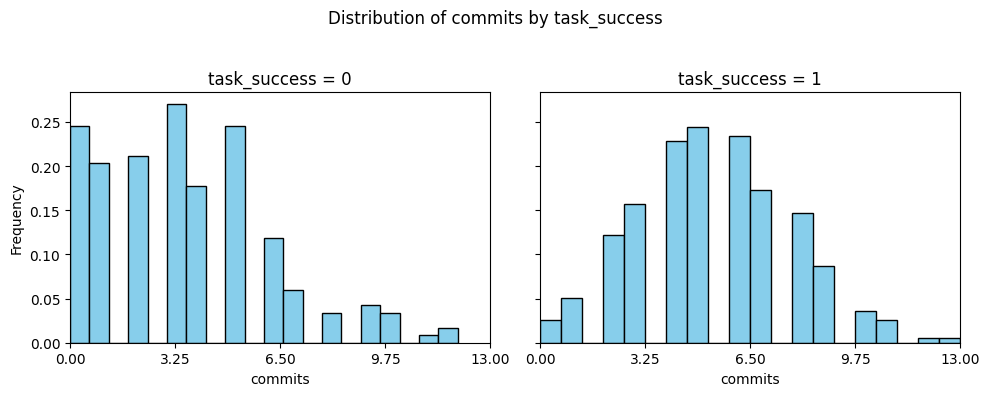

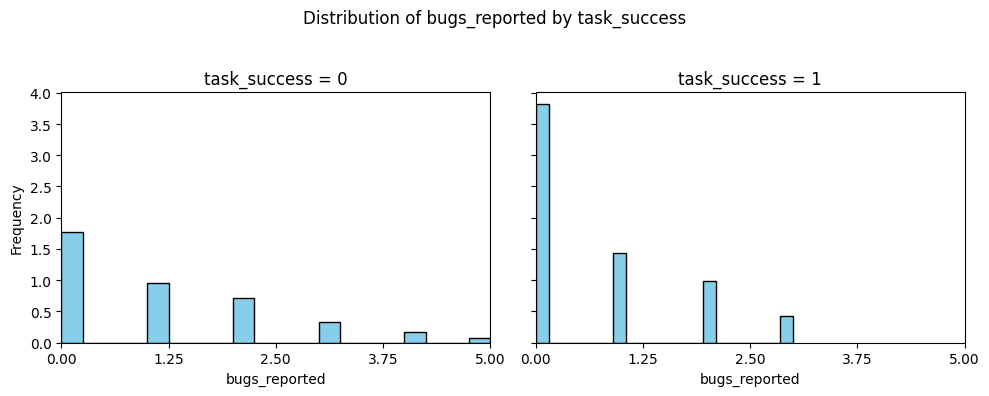

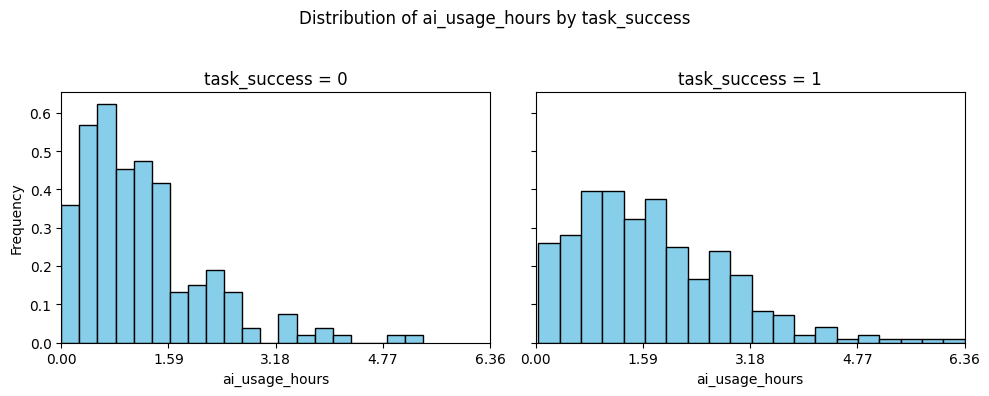

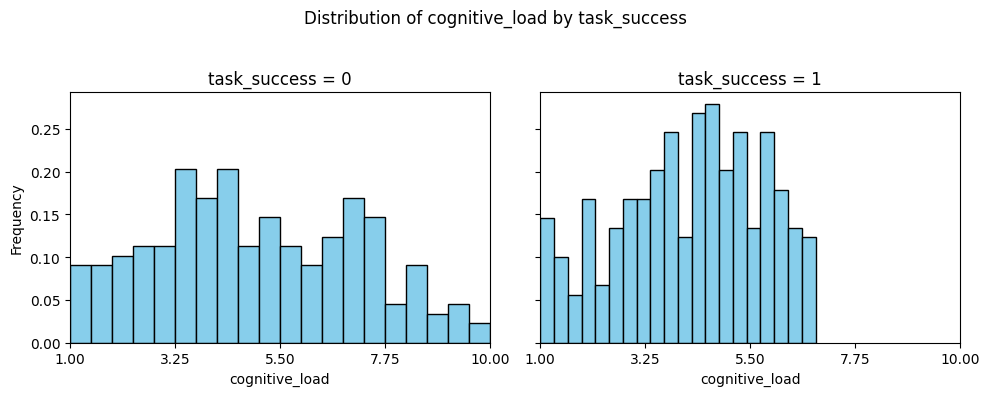

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns.drop('task_success')
unique_values = sorted(df['task_success'].unique())

for col in numeric_cols:
    fig, axes = plt.subplots(1, len(unique_values), figsize=(5 * len(unique_values), 4), sharey=True)
    fig.suptitle(f'Distribution of {col} by task_success')

    # Get global min and max for the column (across all task_success values)
    col_min = df[col].min()
    col_max = df[col].max()

    # Define ticks: 5 ticks between min and max (adjust as needed)
    xticks = np.linspace(col_min, col_max, 5)

    for i, val in enumerate(unique_values):
        ax = axes[i] if len(unique_values) > 1 else axes
        subset = df[df['task_success'] == val]
        ax.hist(subset[col], bins=20, color='skyblue', edgecolor='black', density=True)
        ax.set_title(f'task_success = {val}')
        ax.set_xlabel(col)
        ax.set_xlim(col_min, col_max)
        ax.set_xticks(xticks)
        if i == 0:
            ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


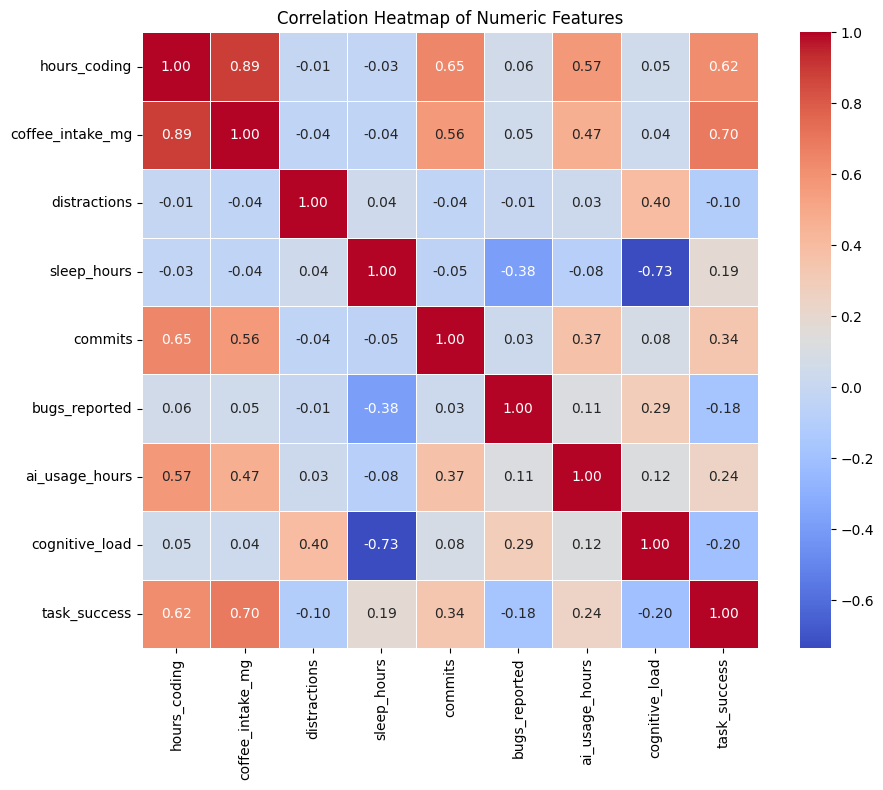

In [ ]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

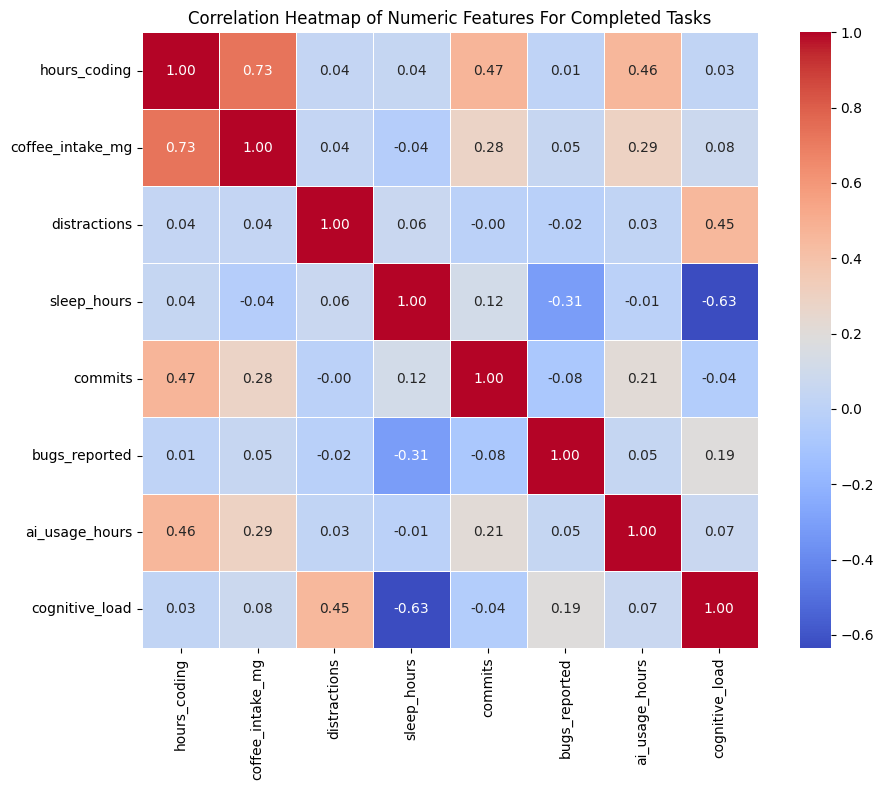

In [ ]:
# Compute correlation matrix
corr = df[df['task_success']==1].drop('task_success',axis=1).corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features For Completed Tasks')
plt.tight_layout()
plt.show()

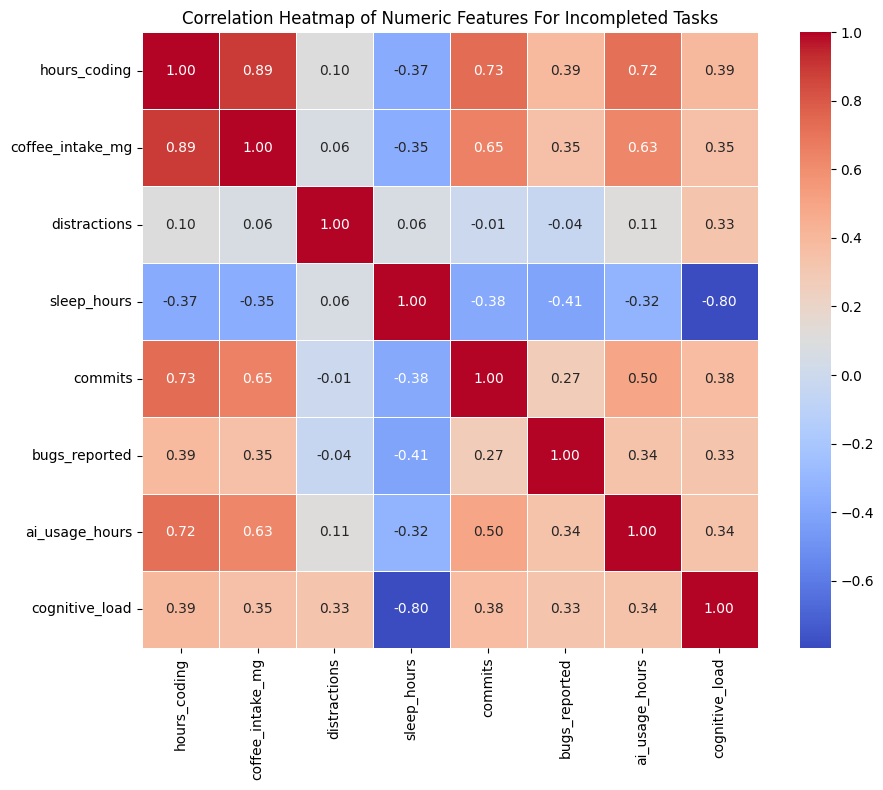

In [ ]:
# Compute correlation matrix
corr = df[df['task_success']==0].drop('task_success',axis=1).corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features For Incompleted Tasks')
plt.tight_layout()
plt.show()

In [ ]:
df[(df['task_success'] == 1)]['coffee_intake_mg'].sort_values()

,coffee_intake_mg
168,318
475,356
101,370
432,374
268,381
...,...
54,600
53,600
20,600
6,600


In [ ]:
df[(df['task_success'] == 0)]['coffee_intake_mg'].sort_values()

,coffee_intake_mg
471,6
74,41
221,41
382,51
13,72
...,...
436,600
361,600
373,600
397,600


# 3. Prediction

In [ ]:


def train_and_evaluate_classifiers(x_train, y_train, x_test, y_test):
  """
  Trains and evaluates various classification models.

  Args:
    x_train: Training features.
    y_train: Training target.
    x_test: Testing features.
    y_test: Testing target.

  Returns:
    A dictionary containing evaluation metrics for each model.
  """
  models = {
      "Logistic Regression": LogisticRegression(),
      "Decision Tree": DecisionTreeClassifier(),
      "Random Forest": RandomForestClassifier(),
      "Gradient Boosting": GradientBoostingClassifier(),
      "AdaBoost": AdaBoostClassifier(),
      "SVC": SVC(probability=True), # probability=True for ROC AUC
      "K-Nearest Neighbors": KNeighborsClassifier(),
      "Gaussian Naive Bayes": GaussianNB()
  }

  results = {}

  for name, model in models.items():
    print(f"Training {name}...")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": cm
    }
    print(f"{name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}" if isinstance(roc_auc, float) else f"  ROC AUC: {roc_auc}")
    print(f"  Confusion Matrix:\n{cm}\n")

  return results


We will try with and without coffee intake

## With coffee intake

In [ ]:
X = df.drop('task_success', axis=1)
y = df['task_success']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
rez = train_and_evaluate_classifiers(x_train, y_train, x_test, y_test)

Training Logistic Regression...
Logistic Regression Evaluation:
  Accuracy: 0.8500
  Precision: 0.9048
  Recall: 0.8636
  F1-Score: 0.8837
  ROC AUC: 0.9225
  Confusion Matrix:
[[28  6]
 [ 9 57]]

Training Decision Tree...
Decision Tree Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training Random Forest...
Random Forest Evaluation:
  Accuracy: 0.9900
  Precision: 1.0000
  Recall: 0.9848
  F1-Score: 0.9924
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 1 65]]

Training Gradient Boosting...
Gradient Boosting Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training AdaBoost...
AdaBoost Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training SVC...
SVC Evaluation:
  Accuracy: 0.9400
  Precision: 0

## Without coffee intake

In [ ]:
X = df.drop(['task_success', 'coffee_intake_mg'], axis=1)
y = df['task_success']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
rez_no = train_and_evaluate_classifiers(x_train, y_train, x_test, y_test)

Training Logistic Regression...
Logistic Regression Evaluation:
  Accuracy: 0.8600
  Precision: 0.9194
  Recall: 0.8636
  F1-Score: 0.8906
  ROC AUC: 0.8766
  Confusion Matrix:
[[29  5]
 [ 9 57]]

Training Decision Tree...
Decision Tree Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training Random Forest...
Random Forest Evaluation:
  Accuracy: 0.9900
  Precision: 1.0000
  Recall: 0.9848
  F1-Score: 0.9924
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 1 65]]

Training Gradient Boosting...
Gradient Boosting Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training AdaBoost...
AdaBoost Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000
  Confusion Matrix:
[[34  0]
 [ 0 66]]

Training SVC...
SVC Evaluation:
  Accuracy: 0.9100
  Precision: 0

## Comparison

In [ ]:
rez

{'Logistic Regression': {'Accuracy': 0.85,
  'Precision': 0.9047619047619048,
  'Recall': 0.8636363636363636,
  'F1-Score': 0.8837209302325582,
  'ROC AUC': np.float64(0.9224598930481284),
  'Confusion Matrix': array([[28,  6],
         [ 9, 57]])},
 'Decision Tree': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'ROC AUC': np.float64(1.0),
  'Confusion Matrix': array([[34,  0],
         [ 0, 66]])},
 'Random Forest': {'Accuracy': 0.99,
  'Precision': 1.0,
  'Recall': 0.9848484848484849,
  'F1-Score': 0.9923664122137404,
  'ROC AUC': np.float64(1.0),
  'Confusion Matrix': array([[34,  0],
         [ 1, 65]])},
 'Gradient Boosting': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'ROC AUC': np.float64(1.0),
  'Confusion Matrix': array([[34,  0],
         [ 0, 66]])},
 'AdaBoost': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'ROC AUC': np.float64(1.0),
  'Confusion Matrix': array([[34,  0],
         [

In [ ]:
rez1_acc = { model: rez[model]['Accuracy'] for model in rez}
rez2_acc = {model: rez_no[model]['Accuracy'] for model in rez_no}

In [ ]:
rez1_acc

{'Logistic Regression': 0.85,
 'Decision Tree': 1.0,
 'Random Forest': 0.99,
 'Gradient Boosting': 1.0,
 'AdaBoost': 1.0,
 'SVC': 0.94,
 'K-Nearest Neighbors': 0.92,
 'Gaussian Naive Bayes': 0.86}

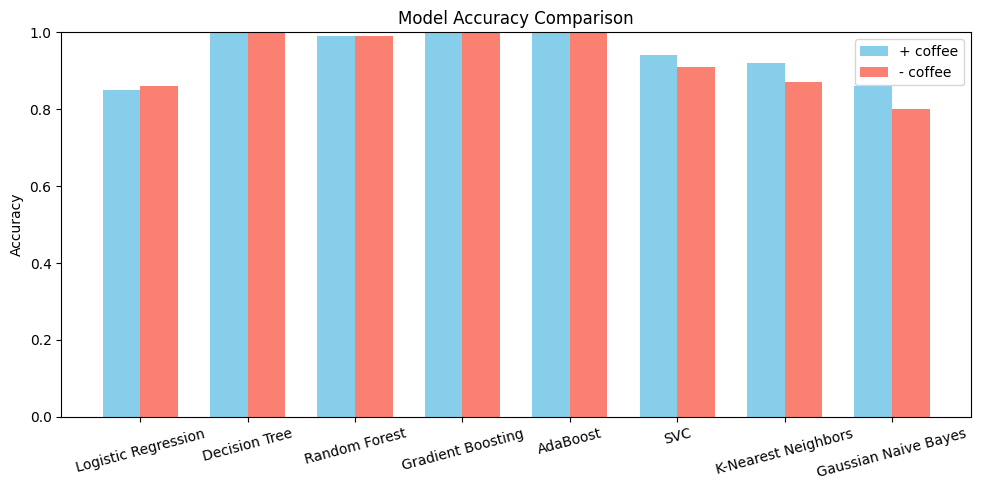

In [ ]:

models = list(rez1_acc.keys())


x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, rez1_acc.values(), width, label='+ coffee', color='skyblue')
plt.bar(x + width/2, rez2_acc.values(), width, label='- coffee', color='salmon')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, models, rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()